### Results Mapping

Takes the finalized predictions (as excel tables created during training) and the mappings of the ROIs on the whole brain as an input and verifies that the ROI voxels in the WB models deliver the same prediction results as the separate ROI models.

In [5]:
import pandas as pd
import numpy as np
import os

In [46]:
# load the excel
r_agg = pd.read_excel('slice_hpo.xlsx')

In [47]:
# filter the dataframe on the best model for each ROI and stage
r_agg = r_agg.loc[r_agg.groupby(['ROI', 'stage'])['correlation_score'].idxmax()]

In [133]:
# aggregate all files in the "slice_results_non_aggregated" folder (results from different server sessions)
folder_path = "slice_results_non_aggregated"
dfs= []

# iterate through all files in the folder
for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)
    # Check if the path is a file and if it has a .xlsx extension
    if os.path.isfile(filepath) and filename.endswith(".csv"):
        # Read the Excel file into a DataFrame and append it to the list
        df = pd.read_csv(filepath)
        dfs.append(df)

# concatenate dfs
results = pd.concat(dfs, ignore_index=True)
print(len(results))

4945164


In [18]:
# filter the results on the best model for every ROI and layer
results = pd.merge(results, r_agg, on=['stage', 'ROI', 'num_hidden_layers', 'learning_rate', 'dropout', 'l2_reg'], how='inner')

In [20]:
results = results.rename(columns={"correlation_score_x": "correlation_score", "correlation_score_y": "correlation_score_total"})
results

,voxel,stage,ROI,sub,num_hidden_layers,learning_rate,dropout,l2_reg,correlation_score,correlation_score_total
0,1,stage_5,WB,sub01,2,0.0001,0.4,0.0001,0.038696,0.087514
1,2,stage_5,WB,sub01,2,0.0001,0.4,0.0001,0.083954,0.087514
2,3,stage_5,WB,sub01,2,0.0001,0.4,0.0001,0.245570,0.087514
3,4,stage_5,WB,sub01,2,0.0001,0.4,0.0001,0.031497,0.087514
4,5,stage_5,WB,sub01,2,0.0001,0.4,0.0001,0.060791,0.087514
...,...,...,...,...,...,...,...,...,...,...
459543,29,stage_5,PPA,sub07,2,0.0001,0.2,0.0010,0.011449,0.146699
459544,30,stage_5,PPA,sub07,2,0.0001,0.2,0.0010,0.063641,0.146699
459545,31,stage_5,PPA,sub07,2,0.0001,0.2,0.0010,0.082361,0.146699
459546,32,stage_5,PPA,sub07,2,0.0001,0.2,0.0010,-0.009263,0.146699


In [22]:
# get scores for each ROI - aggregate ROIs per subject
r_agg_roi = r_agg[~(r_agg["ROI"] == "WB")]

In [33]:
# retrieve the scores for the ROIs from the WB model
r_wb = []
# Iterate over unique stages
for stage in results['stage'].unique():
    # Filter results for the given stage and ROI 'WB'
    filtered_df = results[(results['stage'] == stage) & (results['ROI'] == 'WB')]
    # Iterate over the list of ROIs
    for roi in ["V1", "V2", "V3", "V4", "LOC", "EBA", "FFA", "STS", "PPA"]:
        # Iterate over unique subjects
        for sub in filtered_df['sub'].unique():
            voxel_path = f"roi_maps/{sub}/{roi}_indices.npy"
            if os.path.exists(voxel_path):
                voxels = np.load(voxel_path)
                filtered_df_sub = filtered_df[(filtered_df["sub"] == sub) & (filtered_df['voxel'].isin(voxels))]
                avg_correlation_score = filtered_df_sub['correlation_score'].mean()
                # Append the result to the list
                r_wb.append({
                    'stage': stage,
                    'ROI': roi,
                    'sub': sub,
                    'correlation_score': avg_correlation_score
                })
            else:
                print(f"Error: File not found at {voxel_path}")

In [39]:
r_wb = pd.DataFrame(r_wb)
# group over subs
agg_results = results.groupby(['stage', 'ROI'])['correlation_score'].mean().reset_index()

# Join aggregated correlation scores to r_agg_roi
r_agg_overview = pd.merge(r_agg_roi, agg_results, on=['stage', 'ROI'], how='left')
r_agg_overview = r_agg_overview.rename(columns={"correlation_score_x": "correlation_score_ROI_model",
                                                "correlation_score_y": "correlation_score_WB_model"})

# # analysis was finalized in excel
r_agg_overview.to_excel("correlation_score_comparison.xlsx")

In [42]:
# results variance over subjects
r_wb.to_excel("results_per_subject.xlsx")

### WB results by subject

In [9]:
results = pd.read_csv("test_results_best_models.csv")

In [10]:
results_wb = results[results["ROI"] == "WB"]

In [11]:
# # best model
# results_wb = results_wb[(results_wb['stage'] == 'stage_5') &
#                                   (results_wb['num_hidden_layers'] == 1) &
#                                   (results_wb['dropout'] == 0.4) &
#                                   (results_wb['l2_reg'] == 0.0001)]

# group results per subject
results_wb = results_wb.groupby("sub").agg({"correlation_score": "mean"})
results_wb

,correlation_score
sub,
sub01,0.102095
sub02,0.112156
sub03,0.080866
sub04,0.085402
sub05,0.095312
sub06,0.072887
sub07,0.046896
sub08,0.125918
sub09,0.077751


In [12]:
results_wb["correlation_score"].mean()

0.09180806761249095

### Distribution of Voxel Prediction Scores

In [16]:
results = pd.read_csv("test_results_best_models.csv")

In [17]:
results_wb = results[results["ROI"] == "WB"]

In [18]:
def check_if_roi(row):
    if row["sub"] == sub:  # Check if the current row's subject matches the loop's subject
        return 1 if (row["voxel"] in all_roi_voxels and row["is_roi"] == 0) else row["is_roi"]
    else:
        return row["is_roi"]
# find if voxel is ROI or not
results_wb["is_roi"] = 0
for sub in results_wb["sub"].unique():
    all_roi_voxels = np.empty(0)
    for roi in ["V1", "V2", "V3", "V4", "LOC", "EBA", "FFA", "STS", "PPA"]:
        voxel_path = f"roi_maps/{sub}/{roi}_indices.npy"
        voxels = np.load(voxel_path)
        all_roi_voxels = np.concatenate((all_roi_voxels, voxels))
    print(len(all_roi_voxels))
    results_wb["is_roi"] = results_wb.apply(check_if_roi, axis=1)

3859
3143
3155
3068
2975
3076
2033
2764
3265
2285


In [19]:
results_wb["is_roi"].value_counts()

is_roi
0    131703
1     29623
Name: count, dtype: int64

0.16765346288652802
0.07508313503519036


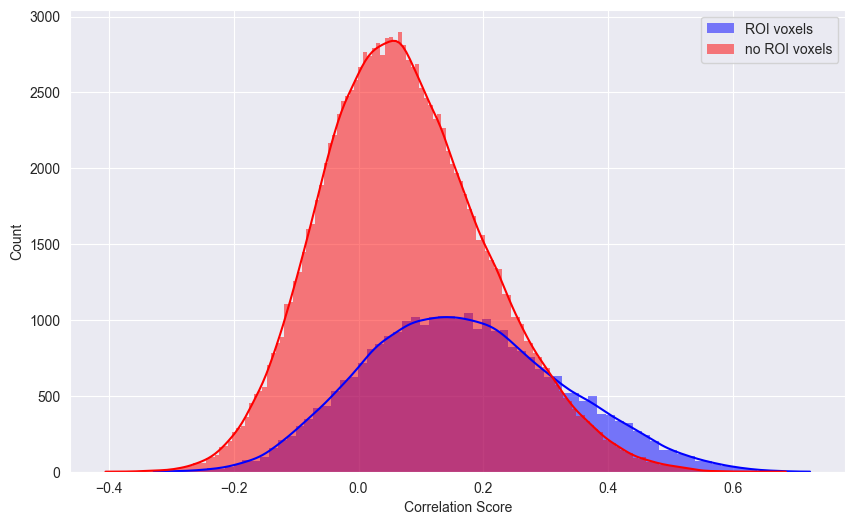

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

roi_data = results_wb[results_wb['is_roi'] == 1]['correlation_score']
print(roi_data.mean())
non_roi_data = results_wb[results_wb['is_roi'] == 0]['correlation_score']
print(non_roi_data.mean())


plt.figure(figsize=(10, 6))
sns.histplot(roi_data, color='blue', label='ROI voxels', kde=True, stat="count", linewidth=0)
sns.histplot(non_roi_data, color='red', label='no ROI voxels', kde=True, stat="count", linewidth=0)
plt.xlabel('Correlation Score')
plt.ylabel('Count')
plt.legend()

# save
plt.savefig('correlation_scores_distribution.png')

# plot
plt.show()